## Data Preprocessing

Diversity: The dataset should represent a diverse population in terms of age, gender, race, and socio-economic background. This will allow the models to consider variations in mental health disorders and treatment responses across different population groups.

Mental Health Diagnoses: The dataset should include patients with various mental health disorders (e.g., depression, anxiety, bipolar disorder, schizophrenia) to capture the complexity and heterogeneity of these conditions.

Demographic Information: The dataset should include demographic features such as age, gender, race, education level, marital status, and socio-economic status.

Mental Health History: The dataset should contain information about patients' mental health history, including previous diagnoses, symptom severity, duration of illness, comorbidities, and family history of mental health disorders.

Treatment History: The dataset should provide comprehensive information on patients' treatment history, including types of treatments (e.g., psychotherapy, medication, electroconvulsive therapy), medications used, dosages, treatment adherence, and treatment outcomes.

--Lifestyle Factors: The dataset should include information on lifestyle factors that may influence mental health and treatment response, such as sleep patterns, physical activity, diet, substance use, and social support.

--Genetic Information: The dataset should include genetic information, such as single nucleotide polymorphisms (SNPs) or other genetic variations associated with mental health disorders or treatment response, if available.

ADMYR: Year of admission Year of client's admission to substance use treatment (All from 2020)

Selected features:
AGE: Age at admission


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Load the dataset
data = pd.read_csv('TEDSA_PUF_2020.csv')

data = data.dropna()  # Drop missing values
data_filtered = data[['AGE', 'GENDER', 'RACE', 'MARSTAT', 'SERVICES']]
df_sample = data_filtered.sample(n=8500, random_state=42)

# Handle missing values
# data.replace(to_replace=r'M', value=np.nan, regex=True)
# data.fillna(0, inplace=True)

# Convert categorical variables to numerical variables
# label_encoder = LabelEncoder()
# data['SERVICES'] = label_encoder.fit_transform(data['SERVICES'])

X = df_sample.drop('SERVICES', axis=1)  # Remove target variable from input features
y = df_sample['SERVICES']  # Target variable

In [39]:
X

array([[-0.43178043, -0.61922796,  0.85753313,  0.65099738],
       [-0.43178043, -0.61922796, -0.07987886, -1.68032389],
       [-0.84557942, -0.61922796,  0.85753313, -1.68032389],
       ...,
       [ 1.22341551, -0.61922796,  0.2325918 ,  0.65099738],
       [ 0.39581754, -0.61922796, -0.07987886,  0.43905908],
       [ 1.22341551,  1.19138011, -0.07987886, -1.68032389]])

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=2)
X_selected = selector.fit_transform(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

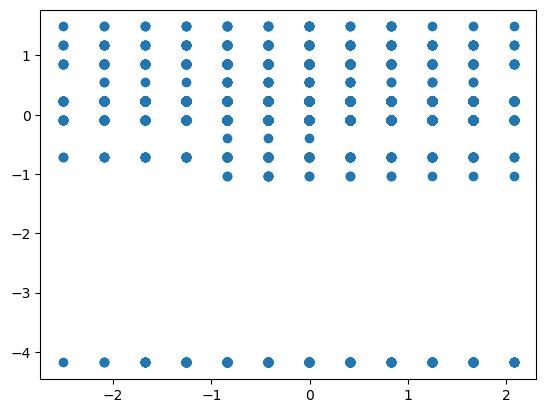

In [47]:
%notebook inline
import matplotlib.pyplot as plt

plt.scatter(X[:,0],X[:,2])

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Train the model
clf = RandomForestClassifier(random_state=42)
params = {'n_estimators': [100],
          'max_depth': [10],
          'min_samples_split': [5]}
grid_search = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10], 'min_samples_split': [5],
                         'n_estimators': [100]},
             scoring='accuracy')

In [49]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Evaluate the model
y_pred = grid_search.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
# print("ROC-AUC: ", roc_auc_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy:  0.5298039215686274
Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00       420
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00       254
           5       0.00      0.00      0.00       182
           6       0.00      0.00      0.00       263
           7       0.53      1.00      0.69      1353
           8       0.00      0.00      0.00        21

    accuracy                           0.53      2550
   macro avg       0.07      0.12      0.09      2550
weighted avg       0.28      0.53      0.37      2550



C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Neural Networks

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential() 
# model.add(Conv2D(filters=64,kernel_size=(5, 5),strides=(1, 1), padding='valid', 
#                  activation='relu',input_shape=(991449, 2))) 
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2))) 
# model.add(Conv2D(filters=32,kernel_size=(3, 3),strides=(1, 1), padding='valid', activation='relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2))) 
# model.add(Conv2D(filters=32,kernel_size=(3, 3),strides=(1, 1), padding='valid', activation='relu')) 
# model.add(Flatten()) 
# model.add(Dense(64,activation='relu')) 
# model.add(Dense(10,activation='softmax')) 

# #Compilemodel 
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

# import time
# start_time = time.time()
# history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))
# end_time = time.time()

# test_loss, test_acc = model.evaluate(X_test, y_test)
# print("Test accuracy:", test_acc)

ValueError: Input 0 of layer "conv2d_6" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 991449, 2)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Support Vector Machines

In [ ]:
# Create a support vector machine model
svm_classifier = SVC(kernel='linear', C=1)

# Train the model
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
# print(f"Test accuracy: {accuracy:.2f}")

## Decision Trees

In [ ]:
# Create a decision tree model
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=123)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)